In [1]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import mobilenet_v2
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.spatial import distance
from scipy.spatial.distance import cosine
from tensorflow.keras.preprocessing import image


In [2]:
dataset_dir = 'dataset'
images_dir = os.path.join(dataset_dir, 'images')
labels_csv = os.path.join(dataset_dir, 'labels.csv')


In [3]:
# Load the model if exists
model = None
if os.path.exists('siamese_model.keras'):
    model = tf.keras.models.load_model('siamese_model.keras')
    print("Model loaded successfully")

Model loaded successfully


In [4]:

def siamese_model(input_shape):
    base_model = mobilenet_v2.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    input1 = keras.Input(shape=input_shape)
    input2 = keras.Input(shape=input_shape)

    x1 = base_model(input1)
    x2 = base_model(input2)
    
    pooled_1 = layers.GlobalAveragePooling2D()(x1)
    pooled_2 = layers.GlobalAveragePooling2D()(x2)

    x = layers.Concatenate()([pooled_1, pooled_2])
    # x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=[input1, input2], outputs=output)
    return model

def retrain_model(model, input_shape, classes):
    if model is None:
        model = siamese_model(input_shape)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_model(model, train_data, train_labels, epochs):
    model.fit(train_data, train_labels, epochs=epochs)
    return model

def load_dataset(images_dir, labels_csv, input_shape, batch_size=32):
    labels_df = pd.read_csv(labels_csv, sep=',')
    labels_list = labels_df.iloc[:, 1:].values
    images = []

    for img_name in labels_df.iloc[:, 0]:
        img_path = os.path.join(images_dir, img_name)
        img = keras.preprocessing.image.load_img(img_path, target_size=input_shape)
        img_array = keras.preprocessing.image.img_to_array(img)
        images.append(img_array)

    images = np.array(images)
    
    labels = [label.split(';') for label in labels_df.iloc[:, 1]]
    classes = sorted(set([item for sublist in labels for item in sublist]))
    mlb = MultiLabelBinarizer(classes=classes)
    labels = mlb.fit_transform(labels)

    return pair_generator(images, labels, batch_size), classes, input_shape, labels_df


def pair_generator(images, labels, batch_size):
    num_samples = len(images)
    
    def generator():
        while True:
            image_pairs_1 = []
            image_pairs_2 = []
            pair_labels = []
            for _ in range(batch_size):
                idx1 = np.random.randint(0, num_samples)
                idx2 = np.random.randint(0, num_samples)
                image_pairs_1.append(images[idx1])
                image_pairs_2.append(images[idx2])
                
                hamming_diff = distance.hamming(labels[idx1], labels[idx2])
                euclidean_diff = distance.euclidean(labels[idx1], labels[idx2])
                diff = (hamming_diff + euclidean_diff) / 2
                similarity_threshold = 0.4

                pair_labels.append([1 if diff <= similarity_threshold else 0])

            yield (np.array(image_pairs_1), np.array(image_pairs_2)), np.array(pair_labels).reshape(-1, 1)

    output_signature = (
        (tf.TensorSpec(shape=(batch_size, *images[0].shape), dtype=tf.float32),
         tf.TensorSpec(shape=(batch_size, *images[0].shape), dtype=tf.float32)),
        tf.TensorSpec(shape=(batch_size, 1), dtype=tf.float32)
    )
    
    return tf.data.Dataset.from_generator(generator, output_signature=output_signature)


In [5]:
# Load dataset (siamese version)
generator, classes, input_shape, labels_df = load_dataset(images_dir, labels_csv, (224,224, 3))

In [6]:
# Retrain model or make a new one if missing
# model = None
model = retrain_model(model, input_shape, classes)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ input_layer_13[0… │
│ (Functional)        │ 1280)             │            │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 2560)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1024)      │  2,622,464 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 1024)      │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │      1,025 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,881,473 (18.62 MB)

 Trainable params: 2,623,489 (10.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

(32, 224, 224, 3) (32, 224, 224, 3) (32, 1)
tf.Tensor(
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]], shape=(5, 1), dtype=float32)


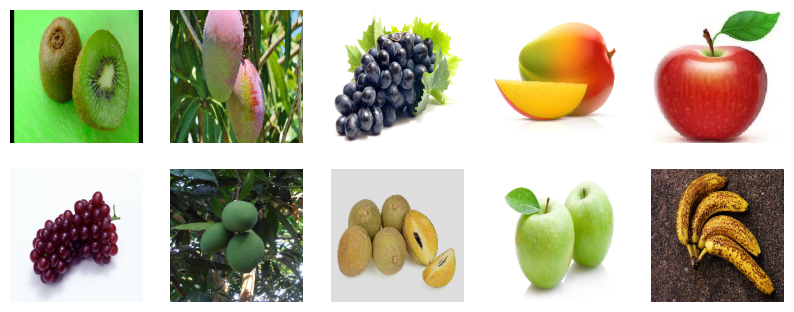

(32, 224, 224, 3) (32, 224, 224, 3) (32, 1)
tf.Tensor(
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]], shape=(5, 1), dtype=float32)


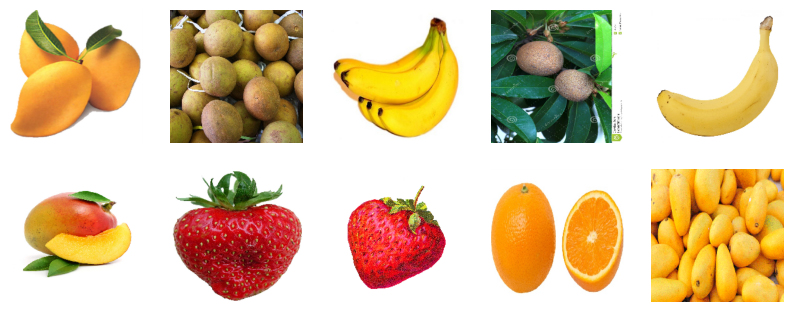

(32, 224, 224, 3) (32, 224, 224, 3) (32, 1)
tf.Tensor(
[[0.]
 [0.]
 [0.]
 [1.]
 [0.]], shape=(5, 1), dtype=float32)


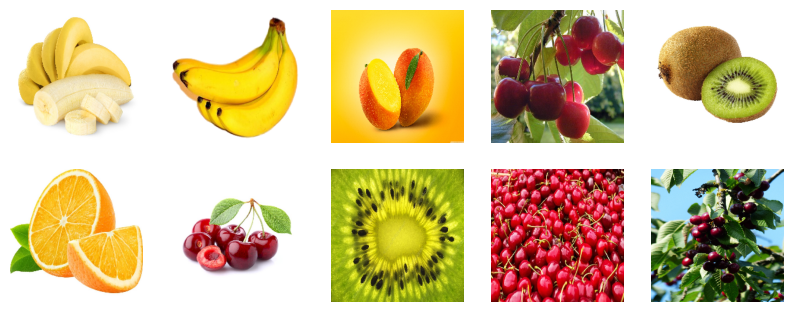

(32, 224, 224, 3) (32, 224, 224, 3) (32, 1)
tf.Tensor(
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]], shape=(5, 1), dtype=float32)


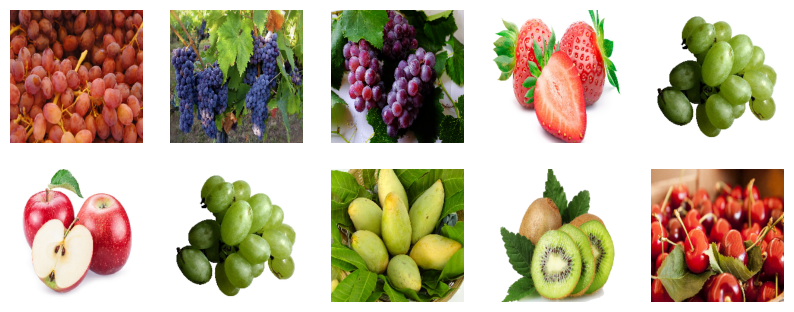

(32, 224, 224, 3) (32, 224, 224, 3) (32, 1)
tf.Tensor(
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]], shape=(5, 1), dtype=float32)


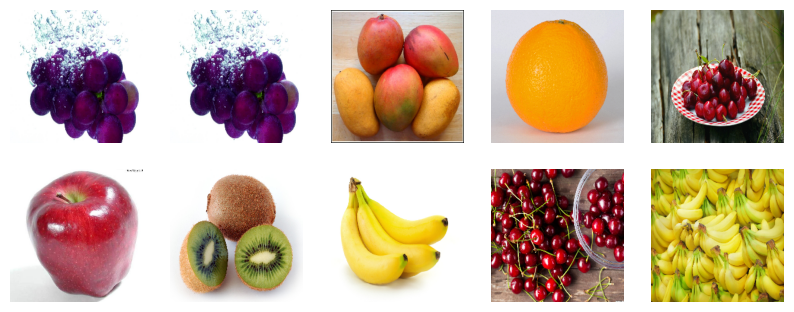

In [7]:
# Test generator
iterator = iter(generator)
for i in range(5):
    image_pairs, labels = next(iterator)
    print(image_pairs[0].shape, image_pairs[1].shape, labels.shape)
    print(labels[:5])

    plt.figure(figsize=(10, 10))
    for i in range(5):
        plt.subplot(5, 5, i + 1)
        plt.imshow(image_pairs[0][i] / 255)
        plt.axis('off')
        
        plt.subplot(5, 5, i + 6)
        plt.imshow(image_pairs[1][i] / 255)
        plt.axis('off')
    plt.show()

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

# Define training settings
train_settings = {
    'epochs': 30,
    'callbacks': [
        EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    ],
    'validation_steps': 10,
    'steps_per_epoch': 10,
    'batch_size': 32,
}

# Train the model with the settings
history = model.fit(generator, epochs=train_settings['epochs'],
                    callbacks=train_settings['callbacks'],
                    steps_per_epoch=train_settings['steps_per_epoch'],
                    validation_steps=train_settings['validation_steps'],
                    batch_size=train_settings['batch_size'])


Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8736 - loss: 0.3965
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9277 - loss: 0.2739
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9283 - loss: 0.2656
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9176 - loss: 0.3175
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8789 - loss: 0.4152
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9509 - loss: 0.2148
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9177 - loss: 0.3090
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9082 - loss: 0.3078
Epoch 9/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 999ms/step - accuracy: 0.9471 - loss: 0.2356
Epoch 10/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9327 - loss: 0.2416
Epoch 11/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9413 - loss: 0.2205
Epoch 12/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9345 -

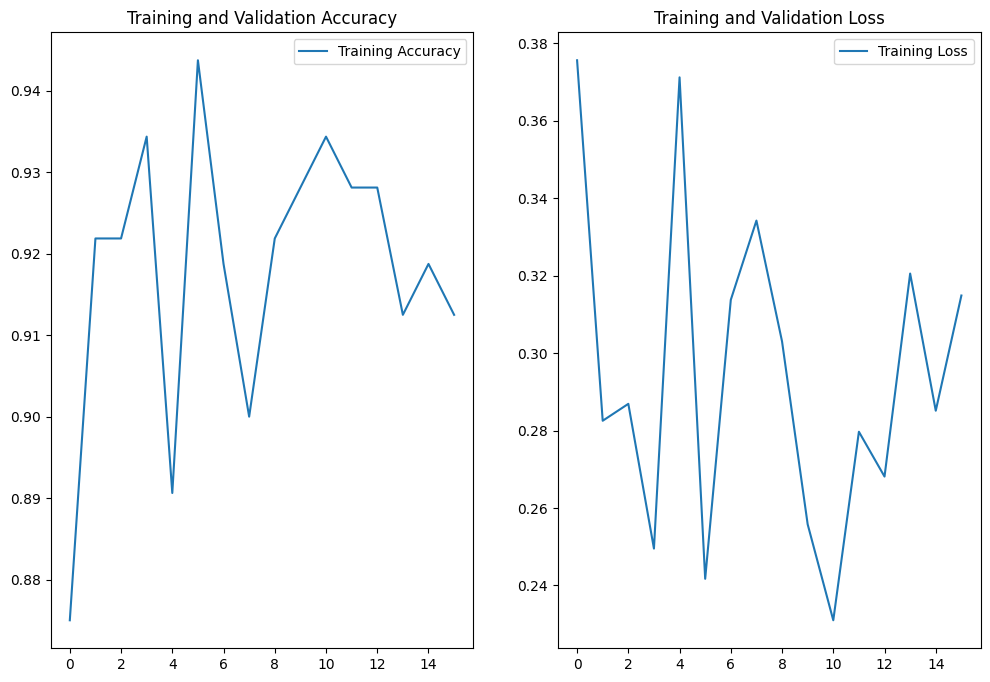

In [9]:
def plot_history(history):
    acc = history.history['accuracy']
    # val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    # val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 8))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    # plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    # plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

# Plot the training history
plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


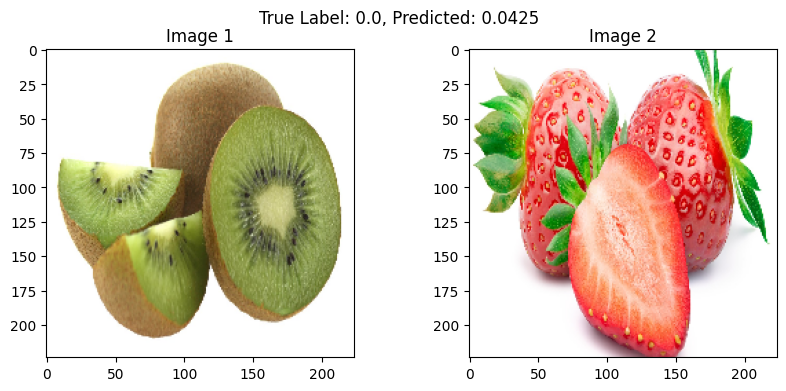

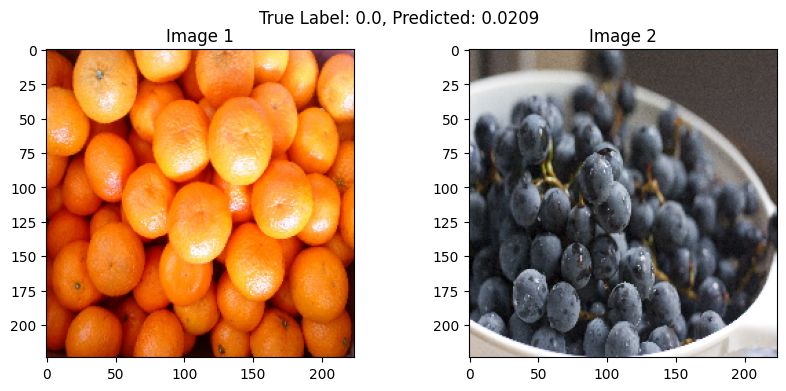

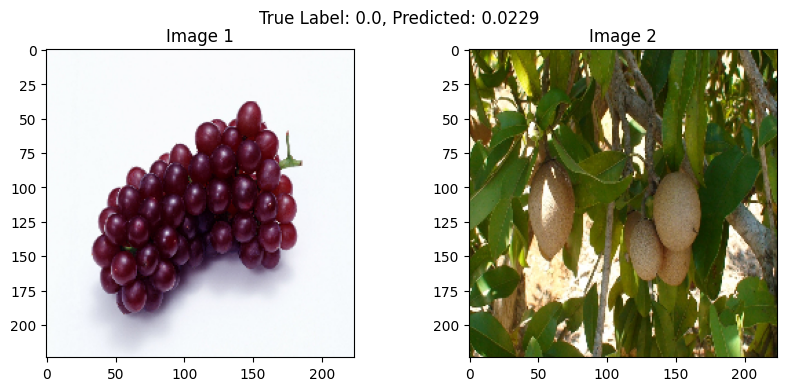

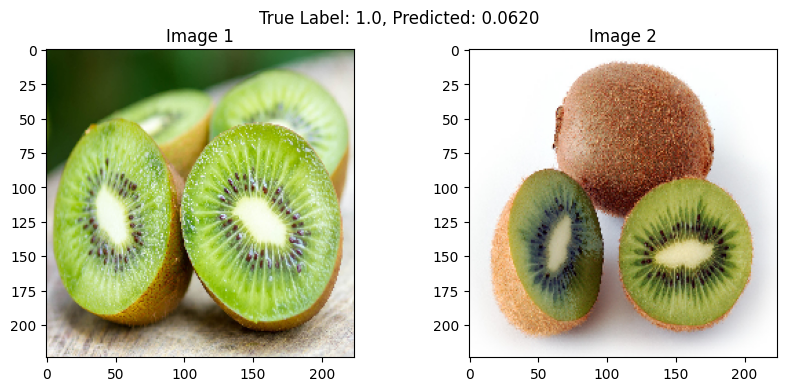

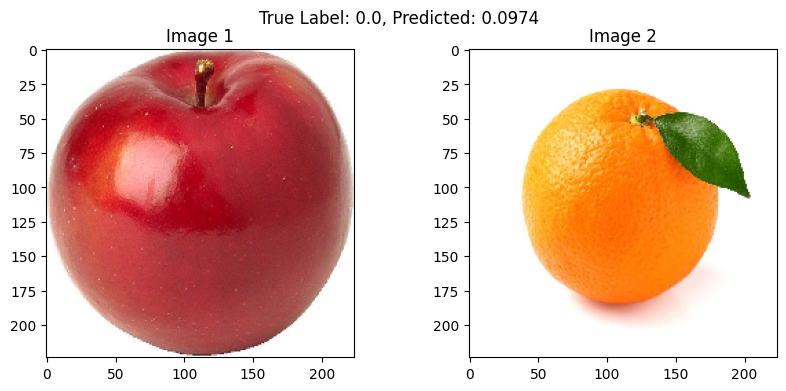

In [10]:
def visualize_predictions(model, test_pairs, test_labels, num_samples=5):
    predictions = model.predict(test_pairs)
    
    for i in range(num_samples):
        plt.figure(figsize=(10, 4))
        
        # Konversi tensor menjadi numpy array untuk digunakan dengan plt.imshow
        image1 = test_pairs[0][i].numpy().astype('uint8')
        image2 = test_pairs[1][i].numpy().astype('uint8')
        
        plt.subplot(1, 2, 1)
        plt.imshow(image1)
        plt.title('Image 1')
        
        plt.subplot(1, 2, 2)
        plt.imshow(image2)
        plt.title('Image 2')
        
        plt.suptitle(f"True Label: {test_labels[i][0]}, Predicted: {predictions[i][0]:.4f}")
        plt.show()

# Mengonversi generator menjadi iterator
iterator = iter(generator)

# Ambil batch pertama dari iterator
test_pairs, test_labels = next(iterator)

# Visualisasikan prediksi
visualize_predictions(model, test_pairs, test_labels)

In [11]:
# Save model
model.save('siamese_model.keras')
print("Model saved successfully")

Model saved successfully


In [ ]:
def create_feature_extractor(base_model, input_shape):
  
    feature_extractor = tf.keras.Model(
        inputs=base_model.input,
        outputs=base_model.get_layer("out_relu").output 
    )
    return feature_extractor


# Ekstrak fitur dari semua gambar di dataset 
def save_features(images_dir, feature_extractor, input_shape, output_file='features.npy'):
    labels_df = pd.read_csv(labels_csv, sep=',')
    images = []

    # Load images
    for img_name in labels_df.iloc[:, 0]:
        img_path = os.path.join(images_dir, img_name)
        img = keras.preprocessing.image.load_img(img_path, target_size=input_shape[:2])
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)  # Preprocess
        images.append(img_array)

    images = np.array(images)

    # Ekstrak fitur menggunakan feature_extractor
    features = feature_extractor.predict(images, batch_size=32)
    
    np.save(output_file, features)
    print(f"Features saved to {output_file}")


# Buat backbone dari model Siamese
base_model = model.layers[2]  

feature_extractor = create_feature_extractor(base_model, input_shape)

# Simpan fitur dataset ke file .npy
save_features(images_dir, feature_extractor, input_shape)


11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 598ms/step
Features saved to features.npy


In [13]:
# Fungsi fitur npy
def load_features(feature_file='features.npy'):
    features = np.load(feature_file)
    # Flatten fitur menjadi array 1D
    features = features.reshape(features.shape[0], -1) 
    print(f"Loaded {features.shape[0]} features from {feature_file}")
    return features


In [ ]:
# Fungsi load gambar dan mengekstrak fitur
def extract_feature_from_image(image_path, feature_extractor, input_shape):
    img = image.load_img(image_path, target_size=input_shape[:2])
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)  
    feature = feature_extractor.predict(np.expand_dims(img_array, axis=0))  
    
    # Flatten fitur menjadi array 1D
    feature = feature.flatten()  
    return feature

# Fungsi pencarian gambar
def search_similar_images(query_image_path, feature_extractor, input_shape, feature_file='features.npy', top_k=5):
    features = load_features(feature_file)
    query_feature = extract_feature_from_image(query_image_path, feature_extractor, input_shape)

    # Hitung cosine similarity 
    similarities = cosine_similarity([query_feature], features)  
    similar_indices = similarities.argsort()[0][::-1] 

    plt.figure(figsize=(12, 12))
    for i in range(top_k):
        idx = similar_indices[i]
        img_path = os.path.join(images_dir, labels_df.iloc[idx, 0])  # Mengambil nama gambar berdasarkan index
        img = image.load_img(img_path, target_size=input_shape[:2])
        
        plt.subplot(1, top_k, i + 1)
        plt.imshow(img)
        plt.title(f"Sim: {similarities[0][idx]:.4f}")
        plt.axis('off')

    plt.show()


In [15]:
from sklearn.preprocessing import MultiLabelBinarizer

# Inisialisasi MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Ubah kolom label menjadi list
labels_list = [labels.split(';') for labels in labels_df.iloc[:, 1]]

# Fit dan transform labels menjadi biner
binary_labels = mlb.fit_transform(labels_list)


In [16]:
def search_by_labels(query, mlb, binary_labels, labels_df, images_dir, input_shape, top_k=10):
    # Preproses query menjadi vektor biner
    query_labels = query.lower().split(', ')
    query_vector = mlb.transform([query_labels])[0]  

    # Hitung skor kecocokan 
    match_scores = binary_labels @ query_vector  
    matching_indices = np.argsort(match_scores)[::-1]  
    matching_indices = [idx for idx in matching_indices if match_scores[idx] > 0]

    if not matching_indices:
        print("Tidak ada gambar ditemukan.")
        return

    # Menampilkan gambar dengan skor tertinggi
    plt.figure(figsize=(15, 12))  
    for i, idx in enumerate(matching_indices[:top_k]):
        img_path = os.path.join(images_dir, labels_df.iloc[idx, 0])  # Ambil nama gambar
        img = image.load_img(img_path, target_size=input_shape[:2])
        
        matched_labels = [mlb.classes_[i] for i in range(len(query_vector)) if binary_labels[idx][i] == 1]
        
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f"Labels: {', '.join(matched_labels)}\nMatch: {match_scores[idx]}")
        plt.axis('off')

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()


Loaded 348 features from features.npy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


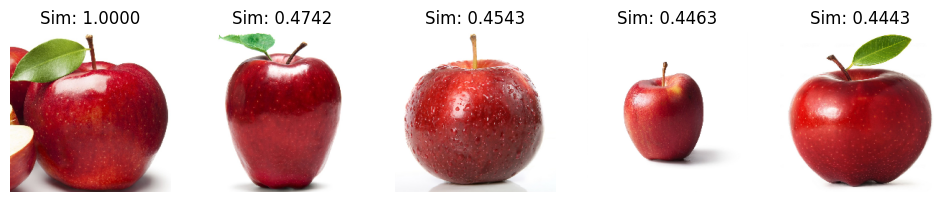

In [17]:

query_image_path = 'dataset/images/apple (14).jpg'  
search_similar_images(query_image_path, feature_extractor, input_shape)

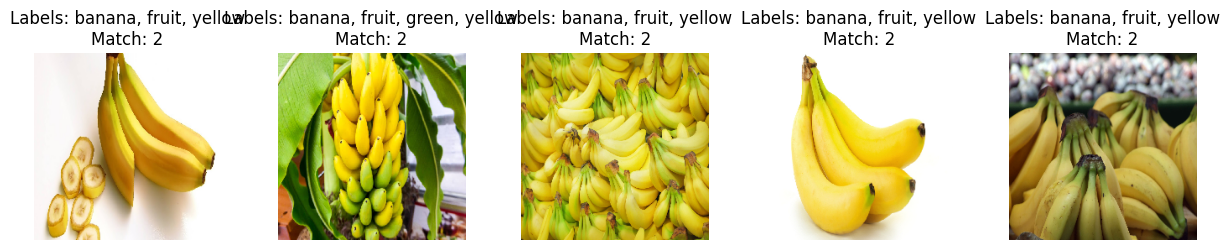

In [18]:

query = "yellow, banana" 
search_by_labels(query, mlb, binary_labels, labels_df, images_dir, input_shape, top_k=5)
